# Short-Term Forecasting Baseline Model:

In [302]:
import numpy as np
import pandas as pd
import yfinance as yf
import fredapi as fa


#ML
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
import hvplot.pandas
import xgboost as xgb


from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import tree
from sklearn.tree import export_graphviz

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

1. Establish the Independent variables & Target variables through looping each country index and, Drop NA values and align the dates

In [307]:
dataframe = pd.read_csv('equity_country_indices.csv', index_col = 0)

data_dict = {
    'y_dict' : {},
    'val_dict' : {},
    'mom_dict' : {}
}

for i in dataframe.columns: # Loop through the country "column" names & insert the formula for each date line
    
    data_dict['y_dict'][i] = (np.log(dataframe[i].shift(-12) / dataframe[i])) #12_M forward

    data_dict['val_dict'][i] = dataframe[i].pct_change(60) # VAL

    data_dict['mom_dict'][i] = dataframe[i].pct_change(12) # MOM

# Set as DF's
y_df = pd.DataFrame(data_dict['y_dict']).dropna(axis=0)
val_df = pd.DataFrame(data_dict['val_dict']).dropna(axis=0)
mom_df = pd.DataFrame(data_dict['mom_dict']).dropna(axis=0)

# Align Dates (full sample)
y_df1 = y_df.loc['1/01/1965':]
val_df1 = val_df.loc[:'1/12/2020']
mom_df1 = mom_df.loc['1/01/1965':'1/12/2020']

### Set the in-sample period:

In [308]:
# SET THE INSAMPLE PERIOD THROUGH THE LOC:
insample_y, insample_val, insample_mom = [df.loc['1/01/1967':'1/01/1980'] for df in [y_df1, val_df1, mom_df1]]

2. Estimate in-sample parameters through closed-form solutions:

In [309]:
reg_results = pd.DataFrame(columns=['country', 'intercept', 'Valuation_beta', 'Momentum_beta'])

    # perform the regression by looping over each country
for country in insample_y.columns:

    #Slicing data for current country
    y = insample_y[country]
    x1 = insample_val[country]
    x2 = insample_mom[country]

    #Create a design Matrix X & insert '1s' in a column:
    X_matrix = np.column_stack((np.ones(len(x1)), x1, x2)) # inserting the looped country values 

#Calculate the regression coefficients through the closed form solution:

#OLS 
    beta_hat = np.linalg.inv(X_matrix.T @ X_matrix) @ X_matrix.T @ y

# #RIDGE
#     n = len(y)
#     X_matrix = np.column_stack((np.ones(n), x1, x2)) # n x 3 matrix of input features
#     I = np.eye(3) # 3 x 3 identity matrix
#     beta_hat = np.linalg.inv(X_matrix.T @ X_matrix + 0.9 * I) @ X_matrix.T @ y # INSERT ALPHA VALUE


    # append the results to the output dataframe
    reg_results = reg_results.append({
        'country': country,
        'intercept': beta_hat[0],
        'Valuation_beta': beta_hat[1],
        'Momentum_beta': beta_hat[2]
    }, ignore_index=True)

3. Display the shrunk parameters across each country to be used on out of sample test:

In [310]:
shrunk_parameters_in_sample = reg_results.mean()
shrunk_parameters_in_sample

/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


intercept         0.068557
Valuation_beta   -0.152655
Momentum_beta     0.058606
dtype: float64

### Set the out of sample period:

In [319]:
# SET THE O_O_SAMPLE PERIOD THROUGH THE LOC:
outsample_y, outsample_val, outsample_mom = [df.loc['1/01/2000':'1/12/2020'] for df in [y_df, val_df, mom_df]]

4. Insert the in-sample shrunk coefficients into the OOS test for each country:

In [320]:
#predicted_OOS_values = Shrunk_Intercept + Shrunk_Val_beta * 5Y_val + Shrunk_Mom_beta * MOM    ~~~ For each country

predicted_OOS_values = pd.DataFrame(columns = y_df1.columns, index = outsample_y.index)
predicted_OOS_values1 = pd.DataFrame(columns = y_df1.columns, index = outsample_y.index)

for i in y_df1.columns:
    value = shrunk_parameters_in_sample[0] + shrunk_parameters_in_sample[1] * outsample_val[i] + shrunk_parameters_in_sample[2] * outsample_mom[i]

    value2 = 0.05 + -0.2 * outsample_val[i] + 0.05 * outsample_mom[i]


    predicted_OOS_values[i] = value
    predicted_OOS_values1[i] = value2

predicted_OOS_values.head()

,US,AU,UK,Germany,France,Japan,Switzerland,India
1/01/2000,-0.157093,-0.030021,-0.101043,-0.157810,-0.212250,0.081905,-0.197744,0.033016
1/02/2000,-0.129904,-0.033958,-0.086222,-0.182946,-0.242122,0.068122,-0.183242,0.015219
1/03/2000,-0.133019,-0.035084,-0.099647,-0.219277,-0.269571,0.050252,-0.206566,0.010918
1/04/2000,-0.136709,-0.018759,-0.081145,-0.199058,-0.235835,0.041244,-0.214396,0.023105
1/05/2000,-0.124886,-0.009396,-0.068325,-0.175765,-0.225449,0.044801,-0.198548,0.023760


5. Define R-Squared function and loop through each country and find OOS R^2 values:

In [321]:
def compute_r_squared(actual, predicted):
    r_squared = (np.corrcoef(predicted, actual))**2
    return r_squared

Create a dictionary and loop through all out of sample actual values and predicted OOS values to find the R^2 for all countries:

In [322]:
corr_dict = {}

for col in y_df1.columns:
    r_squared = compute_r_squared(outsample_y[col], predicted_OOS_values[col])

    corr_dict[col] = r_squared

However, this gives in a weird 2x2 array format, therefore we want to make them into a DF:

In [323]:
# Create a dictionary to store the R-squared values
rsq_dict = {}

# Loop through each country in the dictionary and compute R-squared value
for country, corr_coeffs in corr_dict.items():
    r_squared = corr_coeffs[0,1]*100
    rsq_dict[country] = round(r_squared, 3)

# Convert the dictionary to a dataframe
results_df = pd.DataFrame.from_dict(rsq_dict, orient='index', columns=['OOS_R_squared'])

# Add a column for country names
results_df.index.name = 'Country'
results_df.reset_index(inplace=True)

Do same again for Shane baseline model given constant parameters from before:

In [324]:
corr_dict2 = {}

for col in y_df1.columns:
    r_squared = compute_r_squared(outsample_y[col], predicted_OOS_values1[col])

    corr_dict2[col] = r_squared

In [325]:
# Create a dictionary to store the R-squared values
rsq_dict1 = {}

# Loop through each country in the dictionary and compute R-squared value
for country, corr_coeffs in corr_dict2.items():
    r_squared = corr_coeffs[0,1]*100
    rsq_dict1[country] = round(r_squared, 3)

# Convert the dictionary to a dataframe
results_df2 = pd.DataFrame.from_dict(rsq_dict1, orient='index', columns=['Shane'])

# Add a column for country names
results_df2.index.name = 'Country'
results_df2.reset_index(inplace=True)

Combine them:

In [326]:
combined = pd.concat([results_df, results_df2], join = 'inner', axis =1)
combined

,Country,OOS_R_squared,Country,Shane
0,US,35.452,US,36.028
1,AU,24.775,AU,25.112
2,UK,39.548,UK,39.990
3,Germany,45.705,Germany,45.643
4,France,38.813,France,38.627
5,Japan,10.038,Japan,9.569
6,Switzerland,36.538,Switzerland,36.474
7,India,10.994,India,11.010


Baseline Model coeffs:

![]](https://imgur.com/a/uci5MXi)


<AxesSubplot:xlabel='predicted', ylabel='actual'>

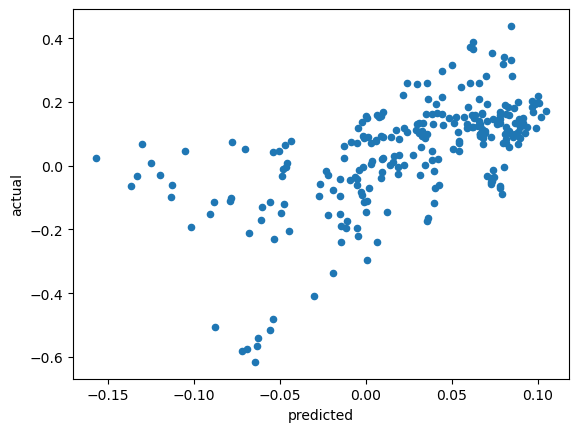

In [327]:
plotter = pd.DataFrame()

plotter['predicted'] = predicted_OOS_values['US']
plotter['actual'] = outsample_y['US']

plotter.plot(kind='scatter', y='actual', x='predicted')

## MSE:

In [328]:
# Loops through 2 seperate dataframes and matches by 'column_name' to determine which columns to perform the function on

mse_df = {country: mean_squared_error(outsample_y[country], predicted_OOS_values[country]) for country in outsample_y}
mse_df_shane = {country: mean_squared_error(outsample_y[country], predicted_OOS_values1[country]) for country in outsample_y}

print(f'First line = new:  {mse_df}\n\n\nSecond Line = Shane:  {mse_df_shane}')

First line = new:  {'US': 0.02137058880320946, 'AU': 0.018514789901890663, 'UK': 0.01808839999107032, 'Germany': 0.03344380396200863, 'France': 0.026937356954313832, 'Japan': 0.04397878642291466, 'Switzerland': 0.020550570407804055, 'India': 0.09264724769598026}


Second Line = Shane:  {'US': 0.02217962551764255, 'AU': 0.01925638821431978, 'UK': 0.015279188635381039, 'Germany': 0.030651936352977326, 'France': 0.02582760249335305, 'Japan': 0.043418639914298535, 'Switzerland': 0.020053250567493585, 'India': 0.13004053650724842}


# ML Models - Decision Tree:

Multi-Indexing: Here we create only 1 dataframe for each IS and OOS:

In [329]:
insample_whole_data = pd.concat([insample_val,insample_mom, insample_y], axis = 1, keys = ['val', 'mom', 'y'])
oossample_whole_data = pd.concat([outsample_val,outsample_mom, outsample_y], axis = 1, keys = ['val', 'mom', 'y'])

Seperate countries into their own dict's (makes it easier for the looping regressions):

In [330]:
country_dfs = {}
country_dfs_oos = {}


# Loop through each country within the second level (e.g. country names) and use the 'xs' cross-section function to make seperate dictionaries for each country
for country in insample_whole_data.columns.levels[1]:
    country_dfs[country] = insample_whole_data.xs(country, level=1, axis=1)

for country in oossample_whole_data.columns.levels[1]:
    country_dfs_oos[country] = oossample_whole_data.xs(country, level=1, axis=1)

### Modelling - Iteratively apply the Tree to each dictioniary:

In [331]:
def ML_2_factor(country_dfs, country_dfs_oos, model_choice):
    
    # Fitting the model & predicting values
    ####################################################################################################################################
    predictions = {}

    for country, data in country_dfs.items():

        X = data.drop(columns = ['y'])

        y = data['y']

        model = model_choice

        model.fit(X,y)

        for country1, data1 in country_dfs_oos.items():

            X1 = data1.drop(columns = ['y'])

        y_pred = model.predict(X1)

        predictions[country] = y_pred


    # MSE & R2 OF MODEL
    ####################################################################################################################################
    mse_of_ml_model = {}
    r2_ml = {}

    for country in country_dfs.keys():

        tree_fa = model_choice.fit(country_dfs[country][['val', 'mom']], 
                                                                country_dfs[country]['y'])
        

        # Make predictions using the tree and compute mse
        y_pred = tree_fa.predict(country_dfs_oos[country][['val', 'mom']])

        mse = mean_squared_error(country_dfs_oos[country]['y'], y_pred)

        ml_r2 = compute_r_squared(country_dfs_oos[country]['y'], y_pred)

        # Store the mse value for the current country in a dictionary
        mse_of_ml_model[country] = mse

        # Store R2 value
        r2_ml[country] = ml_r2


    # Formatting to appending stuff:
    ####################################################################################################################################

        # Create a dictionary to store the R-squared values
        rsq_dict5 = {}

        # Loop through each country in the dictionary and compute R-squared value
        for country, corr_coeffs in r2_ml.items():
            r_squared = corr_coeffs[0,1]*100
            rsq_dict5[country] = round(r_squared, 3)

        # Convert the dictionary to a dataframe
        results_df_ml = pd.DataFrame.from_dict(rsq_dict5, orient='index', columns=['OOS_R_squared'])

        # Add a column for country names
        results_df_ml.index.name = 'Country'
        results_df_ml.reset_index(inplace=True)


    return mse_of_ml_model, results_df_ml, predictions               

Extract MSE's:

In [332]:
decision_tree = ML_2_factor(country_dfs, country_dfs_oos, DecisionTreeRegressor(min_samples_split=50, random_state = 1))

grad_boost = ML_2_factor(country_dfs, country_dfs_oos, GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=10, min_samples_split=50, random_state = 1))

xgboost = ML_2_factor(country_dfs, country_dfs_oos, xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=10, min_samples_split = 50, random_state = 1))

[23:05:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:05:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:05:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/bu

## Compare MSE across OLS, ML:

In [333]:
# create dataframes from dictionaries
df1 = pd.DataFrame.from_dict(mse_df, orient='index', columns=['OLS_new'])
df2 = pd.DataFrame.from_dict(mse_df_shane, orient='index', columns=['OLS_shane'])
df3 = pd.DataFrame.from_dict(decision_tree[0], orient='index', columns=['Decision_Tree'])
df4 = pd.DataFrame.from_dict(grad_boost[0], orient='index', columns=['Gradient_Boost'])
df5 = pd.DataFrame.from_dict(xgboost[0], orient='index', columns=['XG_Boost'])

# concatenate the dataframes along the columns axis
mse_comparison = pd.concat([df1, df2, df3, df4, df5], axis=1)


mse_comparison.hvplot(kind="bar", rot = 90, width = 900, height = 700)

:Bars   [index,Variable]   (value)

## Compare OOS R2 across countries:

In [337]:
cols = ['OLS_base','OLS_Shane', 'Decision Tree','Grad_boost', 'XGBoost']

oos_r2_comparions_init = pd.concat([combined[['OOS_R_squared','Shane']], decision_tree[1], grad_boost[1], xgboost[1]], axis =1)
oos_r2_comparions_init1 = oos_r2_comparions_init.drop(columns = ['Country'])
oos_r2_comparions_init1.index = outsample_y.columns
oos_r2_comparions_init1.columns = cols

oos_r2_comparions_init1.hvplot(kind='bar', rot = 90, width = 900, height = 700)

:Bars   [index,Variable]   (value)